# Experiment 1: Ridge Regression on Forest Fire dataset

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from data import Datafile, load_data
from influence.emp_risk_optimizer import EmpiricalRiskOptimizer
from influence.plot_utils import compare_with_loo
from models.regularized_regression import RegularizedRegression
#from models.hyperplane_clf import BinaryLogisticRegression
#from models.hyperplane_clf import SmoothedSupportVector

## Fit Model
- Use `test_config=[a list of indices]` to evaluate only for some testing points. More testing points -> More unstable.
- Use `leave_indices=[a list of indices]` to run LOO only for some training points.
- traceback_checkpoint: A trainning step where the LOO can pick up. (mainly for speeding up)
- loo_extra_iter: How many extra iterations does the LOO retrain.
- decay_epochs: The number of epoch after which the learning rate is shrinked by a $10^-1$ multiplier.
- batch_size: Size of a minibatch.
- iter_to_switch_to_sgd: The training step after which the optimizer will switch (from adam) to sgd.
- iter_to_switch_off_minibatch: The training step after which the optimizer will switch off minibatch feed_dict evaluation.

In [3]:
X_train, X_test, y_train, y_test, test_indices = load_data(
    Datafile.ForestFire, test_config=[2, 50, 187])
n_tr, p = X_train.shape
n_te, _ = X_test.shape

init_eta = 0.01
batch_size = 100
C = 1.0
train_iter = 50000
traceback_checkpoint = 50000
loo_extra_iter = 5000
decay_epochs = (5000, 8000)
checkpoint_iter = traceback_checkpoint-1
iter_to_switch_to_sgd = np.inf
iter_to_switch_off_minibatch = 20000

np.random.seed(0)
leave_indices = np.random.choice(n_tr, size=150, replace=False)

assert not set(test_indices) & set(leave_indices)
print("Test Indices:", test_indices)
print("Leave Indices:", leave_indices)
# if assertion error, re-evaluate cell

Test Indices: [  2  50 187]
Leave Indices: [283 100  37  46 375  90 238  15 250 233 220 225 282 433 392 400 284 440
 132  45 313  76 271 412  21 205 208 439 113 319 416 446 157 213  75 301
 175  97 162 107 137 303 108 153 155 395 378 118 230   1 394 379 347 224
 325 219 401  96 447  12 336 417 247 413 102 406 340 441 245 463  10 418
 235 508  78  65 391 342 332 236 308 179 511 487 476 276 372 501 264 452
 436 315 493  54 229 278 409 196 309 381  56 188  60 297 311 298  71 170
   6 426 154 195 357 159 481   7 312   8 510 469 134 172 363 194 380  49
 281 231 124 491  59 467 488 437 505 173 142  55 171 144 252 403 393 513
 345  52  74  26 210   4]


In [4]:
tf.reset_default_graph()
model = RegularizedRegression(
    model_name='RidgeRegression-Notebook',
    init_eta=init_eta,
    decay_epochs=decay_epochs,
    batch_size=batch_size,
    C=C
)
model.fit(
    X_train, y_train,
    n_iter=train_iter,
    verbose=1,
    iter_to_switch_off_minibatch=iter_to_switch_off_minibatch,
    iter_to_switch_to_sgd=iter_to_switch_to_sgd,
    traceback_checkpoint=traceback_checkpoint
)

Step 0, Epoch 0: loss = 0.00000000 (0.061 sec)
Step 1000, Epoch 194: loss = 1183.97924805 (0.001 sec)
Step 2000, Epoch 389: loss = 399.82144165 (0.001 sec)
Step 3000, Epoch 583: loss = 12525.00097656 (0.001 sec)
Step 4000, Epoch 778: loss = 837.47467041 (0.001 sec)
Step 5000, Epoch 972: loss = 474.77990723 (0.001 sec)
Step 6000, Epoch 1167: loss = 321.61065674 (0.001 sec)
Step 7000, Epoch 1361: loss = 547.31903076 (0.001 sec)
Step 8000, Epoch 1556: loss = 437.90753174 (0.002 sec)
Step 9000, Epoch 1750: loss = 1692.77880859 (0.001 sec)
Step 10000, Epoch 1945: loss = 1273.34008789 (0.001 sec)
Step 11000, Epoch 2140: loss = 290.17742920 (0.001 sec)
Step 12000, Epoch 2334: loss = 696.07916260 (0.001 sec)
Step 13000, Epoch 2529: loss = 469.95101929 (0.002 sec)
Step 14000, Epoch 2723: loss = 11450.50097656 (0.001 sec)
Step 15000, Epoch 2918: loss = 634.66247559 (0.001 sec)
Step 16000, Epoch 3112: loss = 852.40679932 (0.001 sec)
Step 17000, Epoch 3307: loss = 346.32830811 (0.001 sec)
Step 180

RidgeRegression-Notebook(init_eta=0.01,batch_size=100,decay_epochs=(5000, 8000),C=1.0)

## Evaluate I_loss

In [5]:
I_loss_bf = model.influence_loss(
    X_test, y_test,
    method='brute-force'
)

Fetch training loss gradients (0.293 sec)


In [6]:
I_loss_cg = model.influence_loss(
    X_test, y_test,
    method='cg'
)

Fetch training loss gradients (0.275 sec)
Optimization terminated successfully.
         Current function value: -6872.141602
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 53
         Hessian evaluations: 573
         Current function value: -9977.344727
         Iterations: 21
         Function evaluations: 52
         Gradient evaluations: 59
         Hessian evaluations: 576
         Current function value: -1078.472412
         Iterations: 16
         Function evaluations: 33
         Gradient evaluations: 37
         Hessian evaluations: 557


## Run LOO

In [7]:
loo_diff = model.leave_one_out_refit(
    X_test, y_test,
    n_iter=loo_extra_iter,
    iter_to_load=checkpoint_iter,
    leave_indices=leave_indices
)

INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
LOO Fold 0: loss = 3898.17602539 (2.943 sec)
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from out

INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
LOO Fold 90: loss = 3898.62109375 (6.331 sec)
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from output/RidgeRegression-Notebook-checkpoint-49999
INFO:tensorflow:Restoring parameters from ou

In [8]:
print(leave_indices)
print(I_loss_bf[leave_indices,:]/n_tr)
print(loo_diff)

[283 100  37  46 375  90 238  15 250 233 220 225 282 433 392 400 284 440
 132  45 313  76 271 412  21 205 208 439 113 319 416 446 157 213  75 301
 175  97 162 107 137 303 108 153 155 395 378 118 230   1 394 379 347 224
 325 219 401  96 447  12 336 417 247 413 102 406 340 441 245 463  10 418
 235 508  78  65 391 342 332 236 308 179 511 487 476 276 372 501 264 452
 436 315 493  54 229 278 409 196 309 381  56 188  60 297 311 298  71 170
   6 426 154 195 357 159 481   7 312   8 510 469 134 172 363 194 380  49
 281 231 124 491  59 467 488 437 505 173 142  55 171 144 252 403 393 513
 345  52  74  26 210   4]
[[-3.86693386e+00 -6.99676205e+00 -1.97709258e-01]
 [ 7.30355704e-02  3.09734062e-01 -8.55442151e-02]
 [ 4.54930311e+01  1.57453414e+00 -4.41036857e+00]
 [-4.76668065e-01 -1.18794720e-01  1.35429816e+00]
 [ 9.54760837e-03  3.67405137e+00 -3.75936189e-01]
 [-1.27330688e+00  1.55795442e+00 -1.44316653e+00]
 [ 2.64377460e-01  4.45005187e-01  1.95099114e-01]
 [ 5.55285407e+00  7.25785430e-01

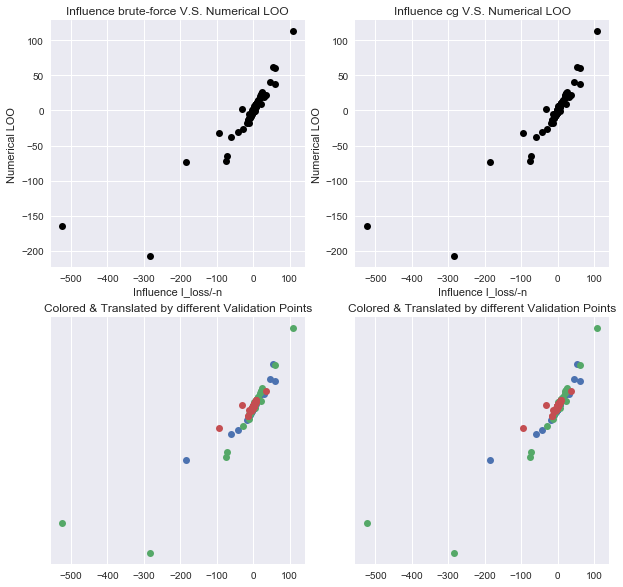

In [9]:
_ = compare_with_loo(
    [I_loss_bf[leave_indices,:], 
     I_loss_cg[leave_indices,:]], loo_diff, n_samples=n_tr)

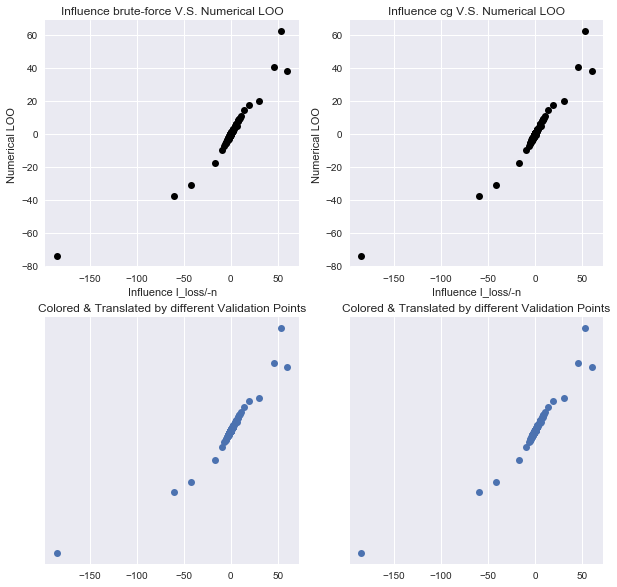

In [15]:
_ = compare_with_loo(
    [I_loss_bf[leave_indices,0:1], 
     I_loss_cg[leave_indices,0:1]], loo_diff, n_samples=n_tr)

In [10]:
a, b = loo_diff.shape
for j in range(n_te):
    print("Test Point %d Correlation: %.4f" % (j, np.corrcoef(
        I_loss_bf[leave_indices, j], loo_diff[:, j])[0][1]))
print("Overall Correlation: %.4f" % np.corrcoef(
        I_loss_bf[leave_indices, :].reshape(a*b,),
        loo_diff.reshape(a*b,))[0][1])

Test Point 0 Correlation: 0.9215
Test Point 1 Correlation: 0.8930
Test Point 2 Correlation: 0.8603
Overall Correlation: 0.8946
